<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/Unet_with_TF2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
import os
import cv2
import tqdm
import glob
import PIL
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import tensorflow.io as tfio
from math import ceil
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/My Drive/Launch pad/kaggle_3m.zip"

Streaming output truncated to the last 5000 lines.
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1_mask.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_27.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_33.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_20_mask.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_21_mask.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_37.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_23.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_22.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_36.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_20.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_34.jpg  
  inflating: kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_40_mask.jpg  
  inflating: kaggl

In [3]:
BASE_PATH = "/content/kaggle_3m"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 200
OUTPUT_CHANNELS = 1

def get_files():
  folders = glob.glob(BASE_PATH + "/*")
  image_list = []
  mask_list = []

  for folder in tqdm(folders):
    file_list = glob.glob(os.path.join(folder, "*.jpg"))
    for file in file_list:
      if 'mask' in file.split('.')[0].split('_'):
        mask_list.append(file)
      else:
        image_list.append(file)

  if len(image_list) == len(mask_list):
    print("success")
  else:
    print("please check your images")

  return image_list, mask_list

images, masks = get_files()

TOTAL_TRAIN = len(images)

100%|██████████| 111/111 [00:00<00:00, 3641.91it/s]

success


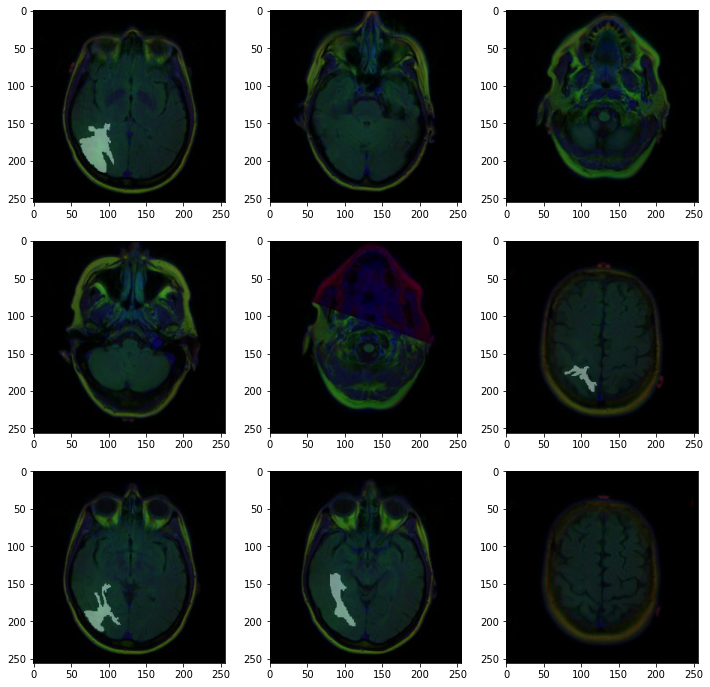

In [4]:
rows, cols = 3, 3

fig = plt.figure(figsize=(12, 12))

for i in range(1, rows * cols + 1):
  fig.add_subplot(rows,cols,i)
  
  img_path = images[i]
  split_path = img_path.split(".")
  mask_path = "".join((split_path[0], "_mask.", split_path[1]))
  img=cv2.imread(img_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  mask=cv2.imread(mask_path)
  plt.imshow(img)
  plt.imshow(mask,alpha=0.4)

plt.show()

In [0]:
def random_crop(image, mask, H=384, W=384):
    image_dims = image.shape
    offset_h = tf.random.uniform(
        shape=(1,), maxval=image_dims[0] - H, dtype=tf.int32)[0]
    offset_w = tf.random.uniform(
        shape=(1,), maxval=image_dims[1] - W, dtype=tf.int32)[0]

    image = tf.image.crop_to_bounding_box(image,
                                          offset_height=offset_h,
                                          offset_width=offset_w,
                                          target_height=H,
                                          target_width=W)
    mask = tf.image.crop_to_bounding_box(mask,
                                         offset_height=offset_h,
                                         offset_width=offset_w,
                                         target_height=H,
                                         target_width=W)
    return image, mask

def get_image(image_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, mask = False, flip = 0):
    img = tf.io.read_file(image_path)
    
    if mask != True:
        img = tf.cast(tf.image.decode_jpeg(img, channels=3), tf.float64)
        img = tf.image.resize(images=img, size=[img_height, img_width])
        img = tf.image.adjust_contrast(img, contrast_factor=1.5)
        img = tf.case([
            (tf.greater(flip, 0), lambda: tf.image.flip_left_right(img))
        ], default=lambda: img)
        img = tf.image.per_image_standardization(img)
    else:
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.cast(tf.image.resize(images=img, size=[img_height, img_width]), dtype=tf.uint8)
        img = img / 255
        img = tf.case([
            (tf.greater(flip, 0), lambda: tf.image.flip_left_right(img))
        ], default=lambda: img)
        
    return img

def load_data(path):
    flip = tf.random.uniform(
        shape=[1, ], minval=0, maxval=2, dtype=tf.int32)[0]
    
    img_path = path
    seg_path = tf.strings.split(img_path, sep=".")
    seg_path = tf.strings.join((seg_path[0], "_mask.", seg_path[1]))
    image, mask = get_image(img_path, flip=flip), get_image(seg_path, mask=True, flip=flip)
    # image, mask = random_crop(image, mask, H=IMG_HEIGHT, W=IMG_WIDTH)
    
    return image, mask

train = tf.data.Dataset.from_tensor_slices((images))
train = train.shuffle(buffer_size=128)
train = train.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

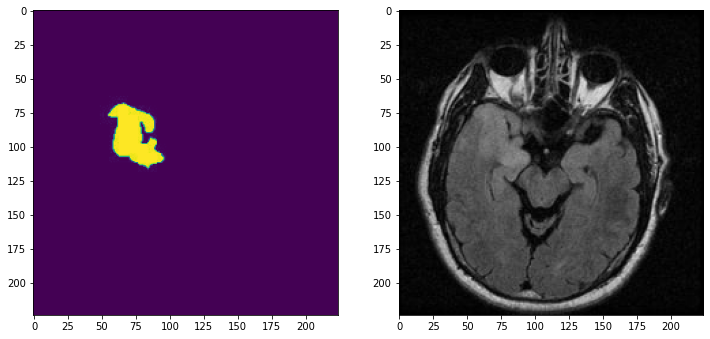

In [6]:
for i in train.take(1):
    fig, ax = plt.subplots(1, 2, figsize=(12, 12))
    ax[0].imshow(tf.keras.preprocessing.image.array_to_img(i[1]))
    ax[1].imshow(tf.keras.preprocessing.image.array_to_img(i[0]))

In [0]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), dilation=1):
    # A block that has a conv layer at shortcut.
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    activation_name_base = 'activation' + str(stage) + block + '_branch'

    strides = (1, 1) if dilation > 1 else strides

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu', name=activation_name_base)(x)

    return x

def identity_block(input_tensor, kernel_size, filters, stage, block, dilation=1):
    # The identity block is the block that has no conv layer at shortcut.
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    activation_name_base = 'activation' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu', name=activation_name_base)(x)

    return x


def ResNet50(input_shape, n_classes = 1000, pooling=None, include_top=False):
    img_input = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = layers.AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = layers.Flatten()(x)
        x = layers.Dense(n_classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    return keras.Model(img_input, x, name='resnet50')

In [0]:
def unet_model(input_shape, output_channels):
  # Base encoder
  base_model = keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

  layer_names = [
      'block_1_expand_relu',   # 64x64
      'block_3_expand_relu',   # 32x32
      'block_6_expand_relu',   # 16x16
      'block_13_expand_relu',  # 8x8
      'block_16_project',      # 4x4
  ]

  base_layers = [base_model.get_layer(layer).output for layer in layer_names]
  down_stack = keras.Model(inputs=base_model.input, outputs=base_layers)
  down_stack.trainable = False
  
  img_input = layers.Input(shape=input_shape)

  # Downsampling through the model
  skips = down_stack(img_input)

  # Upsampling and establishing the skip connections
  x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', use_bias=False)(skips[-1])
  x = layers.Concatenate()([x, skips[-2]])
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', use_bias=False)(x)
  x = layers.Concatenate()([x, skips[-3]])
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', use_bias=False)(x)
  x = layers.Concatenate()([x, skips[-4]])
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False)(x)
  x = layers.Concatenate()([x, skips[-5]])
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  outputs = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same', activation='sigmoid')(x)

  return keras.Model(inputs=img_input, outputs=outputs)

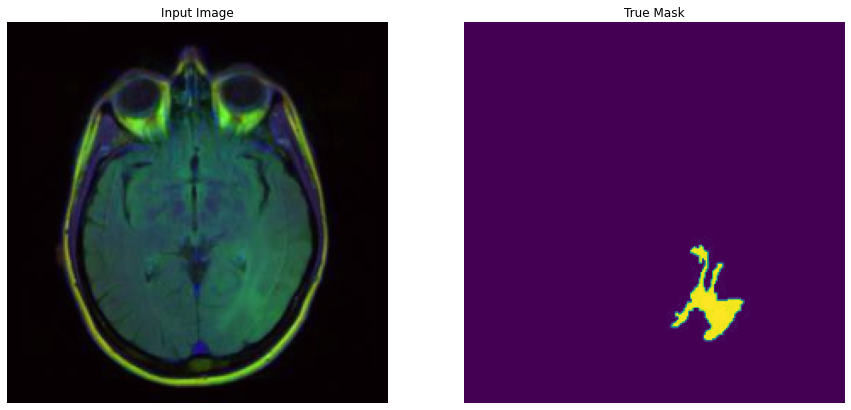

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
def create_mask(pred_mask):
    pred_mask = pred_mask > 0.5
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0] *255, create_mask(pred_mask) *255])
    else:
        display([sample_image, sample_mask *255,
             create_mask(model.predict(sample_image[tf.newaxis, ...])) *255])

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, tf.float32)
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

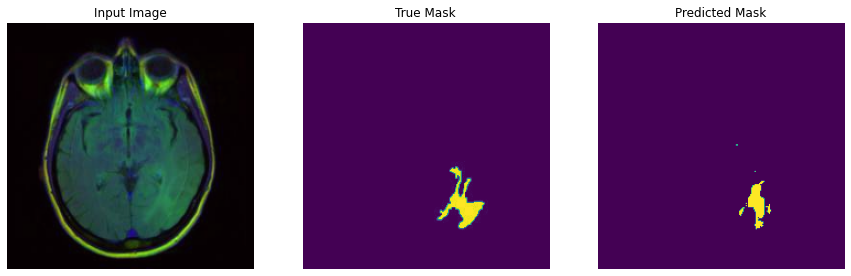


Sample Prediction after epoch 24

200/200 [==============================] - 20s 100ms/step - mean_io_u: 0.5630 - dice_coef: 0.8766 - loss: 0.1426
Epoch 25/200
110/200 [===============>..............] - ETA: 8s - mean_io_u: 0.5671 - dice_coef: 0.8816 - loss: 0.1391

KeyboardInterrupt: ignored

In [16]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    iou = tf.keras.metrics.MeanIoU(OUTPUT_CHANNELS + 1)
    model = unet_model((IMG_HEIGHT, IMG_WIDTH, 3), OUTPUT_CHANNELS)
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
      loss=bce_dice_loss,
      metrics=[iou, dice_coef])

tb = TensorBoard(log_dir='logs', write_graph=True, update_freq='batch')
mc = ModelCheckpoint(mode='min', filepath='top_weights.h5',
                     monitor='val_loss',
                     save_best_only='True',
                     save_weights_only='True', verbose=1)
rlr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)
ds = DisplayCallback()

callbacks = [ds]

model_history = model.fit(train_dataset,
                        epochs=EPOCHS,
                        steps_per_epoch=200,
                        callbacks=callbacks)

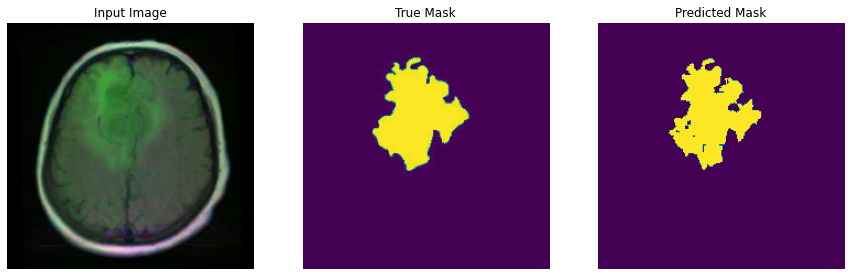

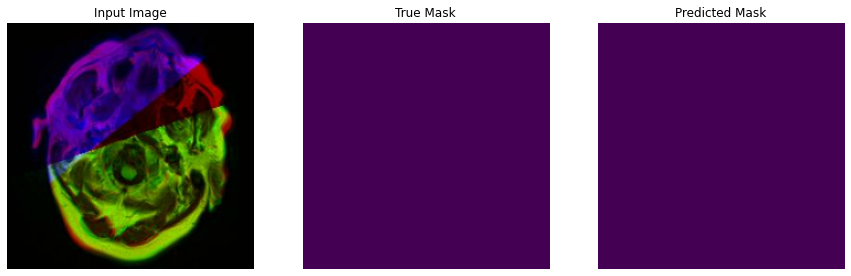

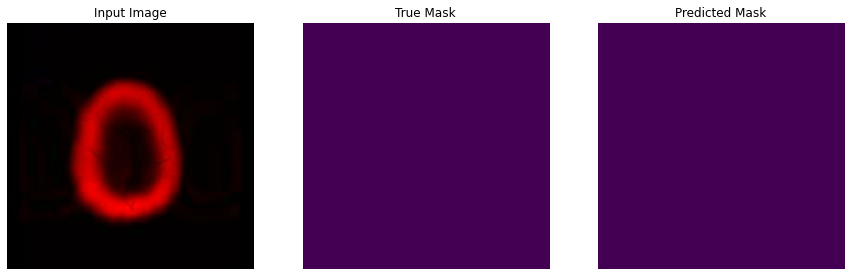

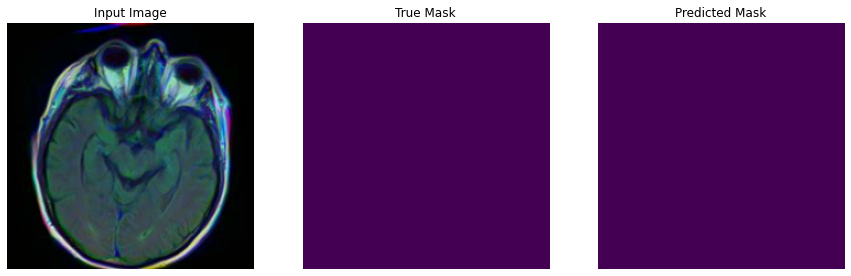

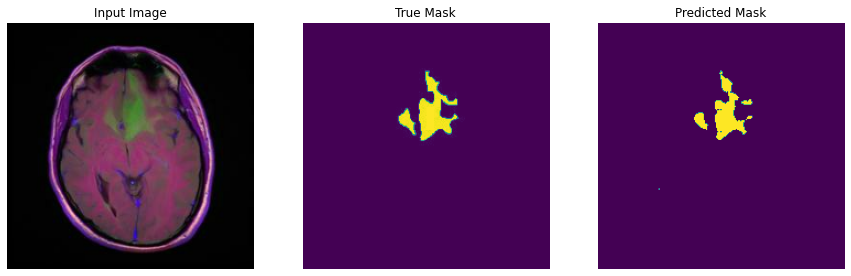

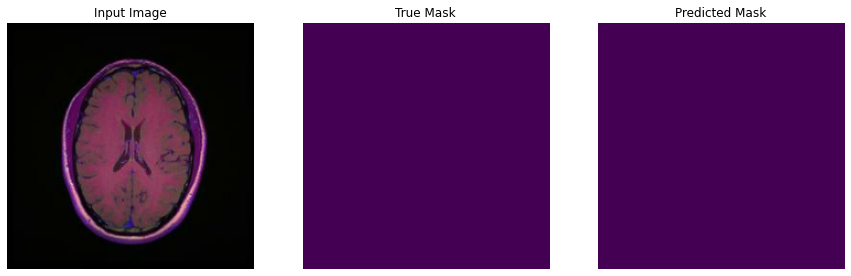

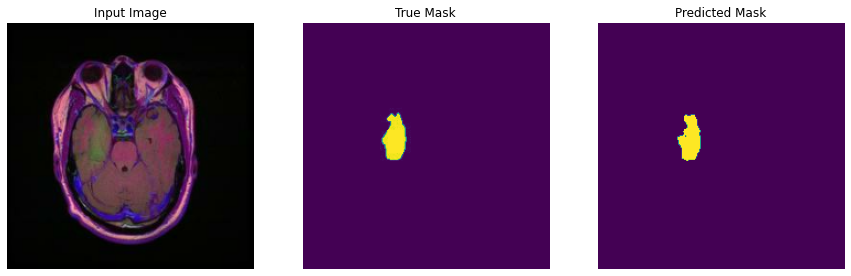

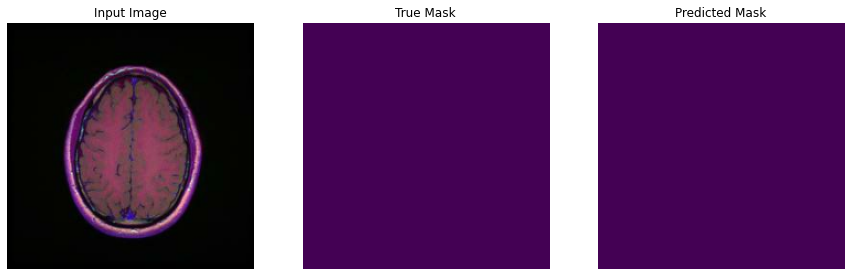

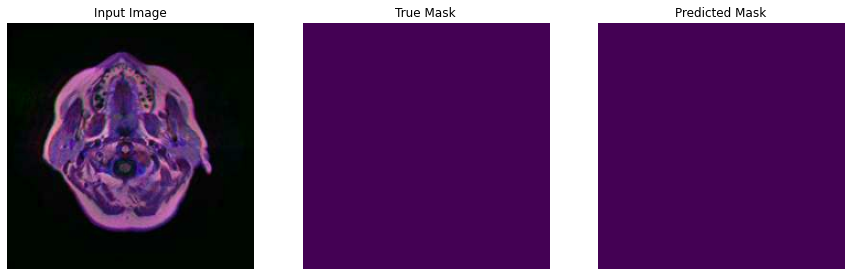

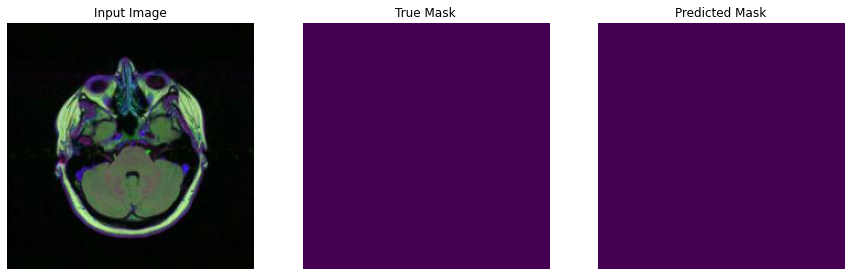

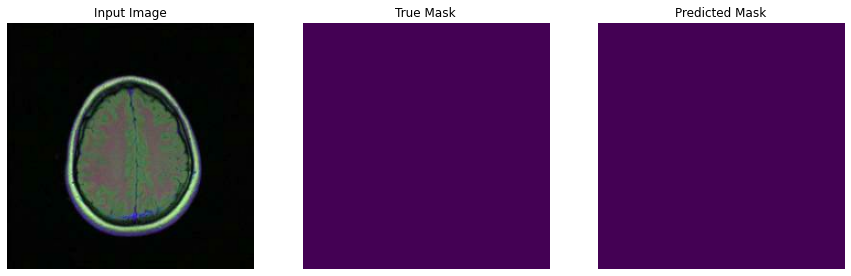

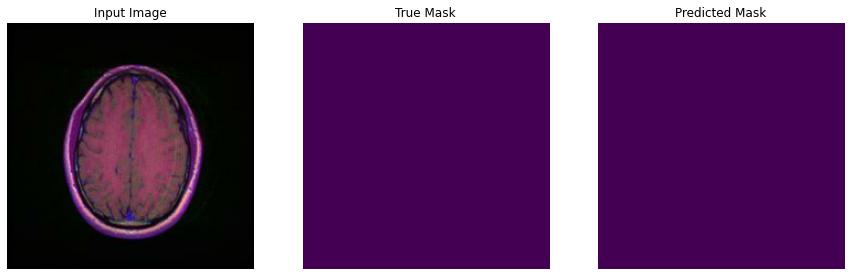

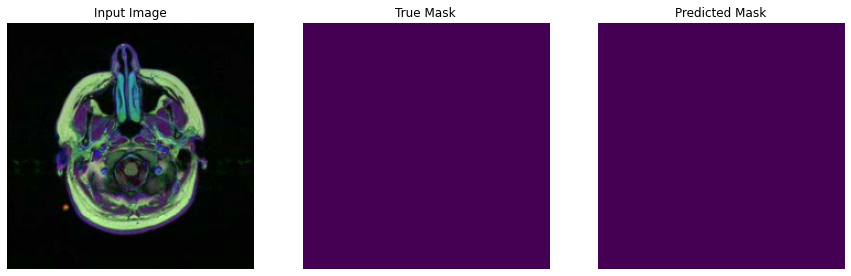

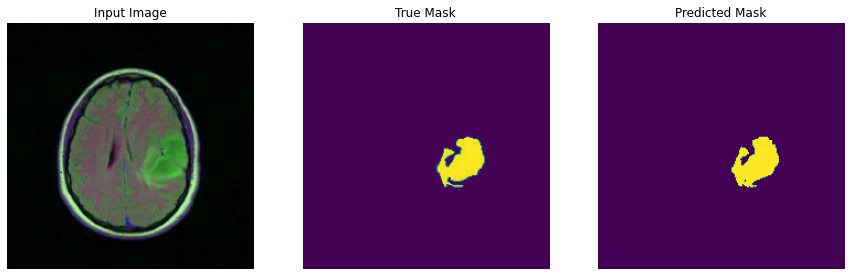

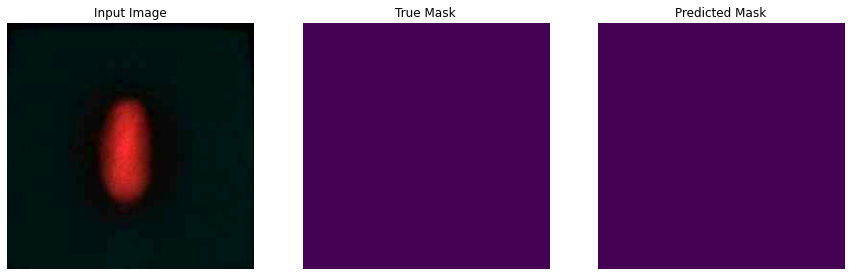

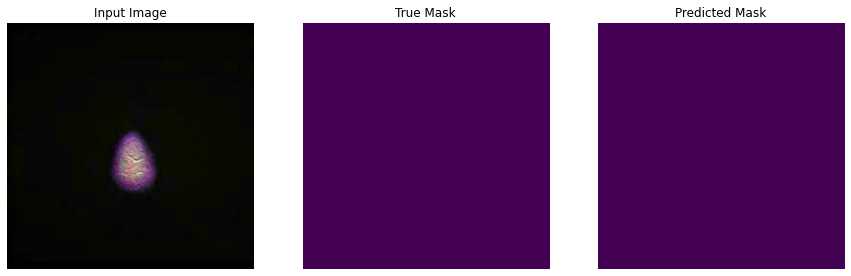

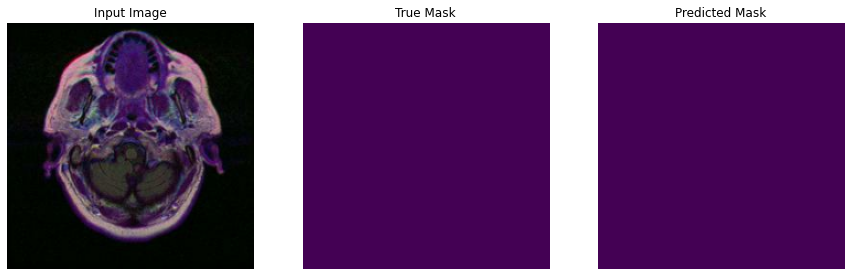

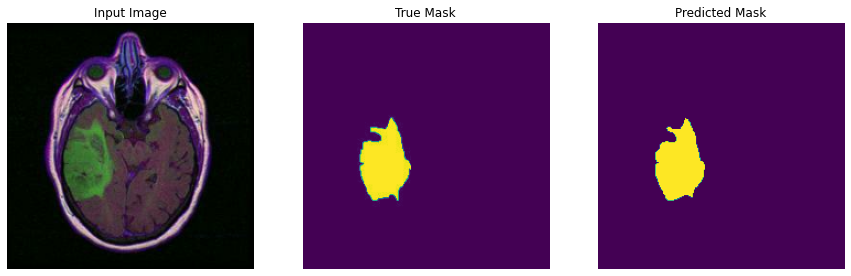

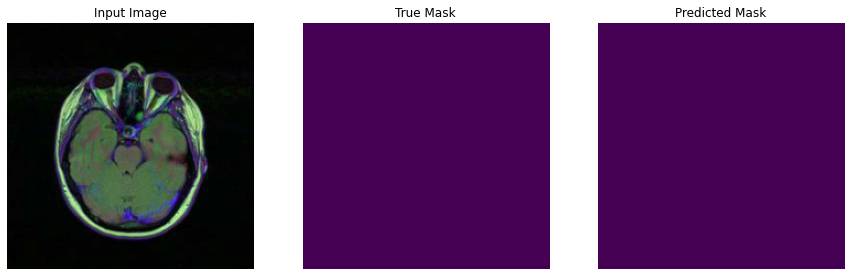

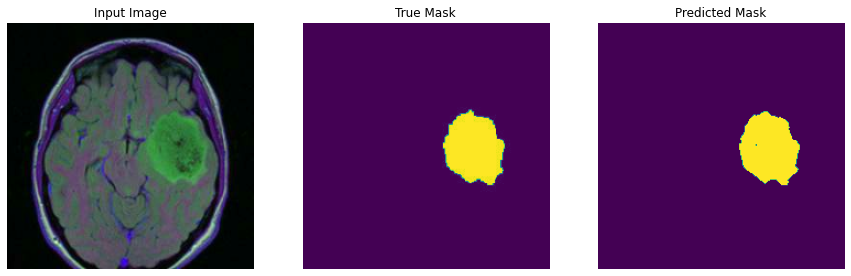

In [33]:
show_predictions(train_dataset, 20)